In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# File and Directory Paths
qa_pair_file = "qa_pairs.csv"
qa_pair_filtered_file = "qa_pairs_filtered.csv"

# Defining column indexes
object_id_index = 0
object_type_index = 1
question_index = 2
answer_index = 3

In [3]:
FIXED_ROW_LENGTH = 4

def check_row_length(file_path, row_length):
    """
    Checks if all rows in a csv file have the expected length.
    
    Args:
        file_path (str): The path to the csv file.
        row_length (int): The expected number of columns in each row.
        
    Returns:
        set: A set of corrupted rows that do not match the expected length.
    """
    corrupted_objects = set()
    
    with open(file_path, "r", encoding="utf-8") as metadata:
        spamreader = csv.reader(metadata, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in spamreader:
            if len(row) != row_length:
                corrupted_objects.add(row[question_index])
                print(f"Unexpected row length of {len(row)} for: {row}")
                
    print(f"{len(corrupted_objects)} rows were corrupted.")
    return corrupted_objects

In [4]:
def count_labels(file_path):
    """
    This functions counts the number of rows per category.
    
    Args:
        file_path (str): Path to the csv file containing the QA-pairs.
    """
    df = pd.read_csv(file_path, delimiter=";", quotechar="|", header=None)
    print(f"Overall: {len(df)}")
    print(df.iloc[:, object_type_index].value_counts())

In [5]:
def check_question_ending(file_path, verbose=False):
    """
    Checks if the questions end with a question mark.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        verbose (bool, optional): Whether to print corrupted rows. Defaults to False.
        
    Returns:
        set[str]: Set of corrupted questions.
    """
    corrupted_objects = set()
    
    with open(file_path, "r", encoding="utf-8") as metadata:
        spamreader = csv.reader(metadata, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in spamreader:
            if row[2][-1] != '?':  # Check if the question does not end with a question mark
                corrupted_objects.add(row[question_index])
                if verbose:
                    print(f"Missing question mark for: {row[question_index]}")
    
    print(f"{len(corrupted_objects)} questions without a question mark were found.")
    return corrupted_objects

In [6]:
def find_not_unique_questions(file_path):
    """
    Locating questions that are not unique, meaning they occur multiple times within the dataset.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        
    Returns:
        set[str]: A set of all non-unique questions.
    """
    df = pd.read_csv(file_path, delimiter=";", quotechar="|", header=None)
    value_counts = df.iloc[:, question_index].value_counts()
    not_unique_questions = value_counts[value_counts >= 2]
    
    print(f"Number of not unique questions: {len(not_unique_questions)}")
    print(f"Number of affected pairs: {not_unique_questions.sum()}")
    print("\nExamples for not unique questions:")
    print(not_unique_questions[:10])
    
    question_set = set()
    for question in not_unique_questions.index:
        question_set.add(question)
    return question_set

In [7]:
def find_long_answers(file_path, threshold_question, threshold_answer):
    """
    Locating all QA-pairs that contain a question or answer with a higher word count than a defined threshold.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        threshold_question (int): The maximum number of words a question is allowed to have.
        threshold_answer (int): The maximum number of words an answer is allowed to have.
        
    Returns:
        set[str]: A set of all questions with too long content.
    """   
    df = pd.read_csv(file_path, delimiter=";", quotechar="|", header=None, usecols=[question_index, answer_index], dtype=str)
    question_word_counts = df[question_index].str.split().str.len()
    answer_word_counts = df[answer_index].str.split().str.len()
    
    too_long_qa_pairs = df.loc[(question_word_counts > threshold_question) | 
                                   (answer_word_counts > threshold_answer), question_index]
    too_long_qa_pairs = set(too_long_qa_pairs)
    
    print(f"{len(too_long_qa_pairs)} too-long pairs have been found")
    return too_long_qa_pairs

In [8]:
def find_text_mention_references(file_path):
    """
    Locating all QA-pairs where either the question or the answer specifically mentions the term 'text mention'.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        
    Returns:
        set[str]: A set of all found questions containing the term 'text mention'.
    """
    df = pd.read_csv(file_path, delimiter=";", quotechar="|", header=None, usecols=[question_index, answer_index], dtype=str)
    df = df[df.apply(lambda row: row.astype(str).str.contains('text mention', case=False, na=False).any(), axis=1)]
    filtered_questions = set(df[question_index])
    
    print(f"{len(filtered_questions)} text mention-referencing pairs have been found")
    return filtered_questions

In [9]:
def get_qa_pair_statistics(file_path, object_type):
    """
    Analyzes the qa_pairs and prints statistics.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        object_type (str): The type of the object which shall be analyzed. Must be of {'Table', 'Figure', 'Overall'}.
        
    Raises:
        ValueError: If 'object_type' is not one of the expected values.
    """
    # Checking object_type
    if object_type not in ["Table", "Figure", "Table_02", "Overall"]:
        raise ValueError("Object_type must be of {'Table', 'Figure', 'Table_02', 'Overall'}.")
    
    # Defining bins for grouping
    bins_questions = [0, 5, 10, 15, 20, 25, 30, 35, 40, float('inf')]
    labels_questions = ["<=5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40", ">40"]
    bins_answers = [0, 1, 2, 3, 4, 5, float('inf')]
    labels_answers = ["1", "2", "3", "4", "5", ">5"]
    bins_answers_02 = [0, 3, 6, 9, 12, 15, 18, 21, float('inf')]
    labels_answers_02 = ["<=3", "4-6", "7-9", "10-12", "13-15", "16-18", "19-21", ">21"]
    
    # Loading and sampling
    df = pd.read_csv(file_path, delimiter=";", quotechar="|", header=None)
    if object_type != "Overall":
        df = df[df.iloc[:, object_type_index] == object_type]
    
    # Getting word counts
    word_counts_question = df.iloc[:, question_index].astype(str).apply(lambda x: len(x.split()))
    word_counts_answer = df.iloc[:, answer_index].astype(str).apply(lambda x: len(x.split()))
    
    # Getting min, mean, median and max word lenghts
    min_question_length = word_counts_question.min()
    min_answer_length = word_counts_answer.min()
    average_question_length = word_counts_question.mean()
    average_answer_length = word_counts_answer.mean()
    median_question_length = word_counts_question.median()
    median_answer_length = word_counts_answer.median()
    max_question_length = word_counts_question.max()
    max_answer_length = word_counts_answer.max()
    
    # Getting word distribtuions for questions
    word_count_distribution_question = pd.cut(word_counts_question, bins=bins_questions, labels=labels_questions, right=True)
    distribution_counts_question = word_count_distribution_question.value_counts().sort_index()
    distribution_counts_question.name = "Question word count"
    
    # Getting word distribtuions for answers (small range)
    word_count_distribution_answer = pd.cut(word_counts_answer, bins=bins_answers, labels=labels_answers, right=True)
    distribution_counts_answer = word_count_distribution_answer.value_counts().sort_index()
    distribution_counts_answer.name = "Answer word count"
    
    # Getting word distribtuions for answers (big range)
    word_count_distribution_answer_02 = pd.cut(word_counts_answer, bins=bins_answers_02, labels=labels_answers_02, right=True)
    distribution_counts_answer_02 = word_count_distribution_answer_02.value_counts().sort_index()
    distribution_counts_answer_02.name = "Answer word count"
    
    # Print average and max values
    print(f"{object_type} results:\n")
    print(f"Min question length: {min_question_length} words")
    print(f"Median question length: {median_question_length} words")
    print(f"Average question length: {round(average_question_length, 2)} words")
    print(f"Max question length: {max_question_length} words\n")
    print(f"Min answer length: {min_answer_length} words")
    print(f"Median answer length: {median_answer_length} words")
    print(f"Average answer length: {round(average_answer_length, 2)} words")
    print(f"Max answer length: {max_answer_length} words\n")
    
    # Print word count distributions
    print("Word count distribution for questions:")
    print(distribution_counts_question)
    print("\nWord count distributions for answers (small range):")
    print(distribution_counts_answer)
    print("\nWord count distributions for answers (big range):")
    print(distribution_counts_answer_02)
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    distribution_counts_question.plot(kind="bar",
                                      ax=axes[0][0],
                                      title="Question Word Count Distribution",
                                      ylabel="Number of Questions",
                                      xlabel="Word Count Range")
    distribution_counts_answer.plot(kind="bar",
                                    ax=axes[0][1],
                                    title="Answer Word Count Distribution",
                                    ylabel="Number of Answers",
                                    xlabel="Word Count Range",
                                    color="forestgreen")
    distribution_counts_question.plot(kind="bar",
                                      ax=axes[1][0],
                                      title="Question Word Count Distribution",
                                      ylabel="Number of Questions",
                                      xlabel="Word Count Range")
    distribution_counts_answer_02.plot(kind="bar",
                                    ax=axes[1][1],
                                    title="Answer Word Count Distribution",
                                    ylabel="Number of Answers",
                                    xlabel="Word Count Range",
                                    color="forestgreen")
    plt.tight_layout()
    plt.show()

Overall results:

Min question length: 3 words
Median question length: 18.0 words
Average question length: 18.74 words
Max question length: 48 words

Min answer length: 1 words
Median answer length: 5.0 words
Average answer length: 7.01 words
Max answer length: 145 words

Word count distribution for questions:
<=5        258
6-10      2170
11-15    25085
16-20    48252
21-25    27643
26-30     7355
31-35     1244
36-40      131
>40         22
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     33011
2     10103
3      7629
4      5108
5      5152
>5    51157
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      50743
4-6      15117
7-9      14116
10-12    11290
13-15     7976
16-18     5039
19-21     3134
>21       4745
Name: Answer word count, dtype: int64


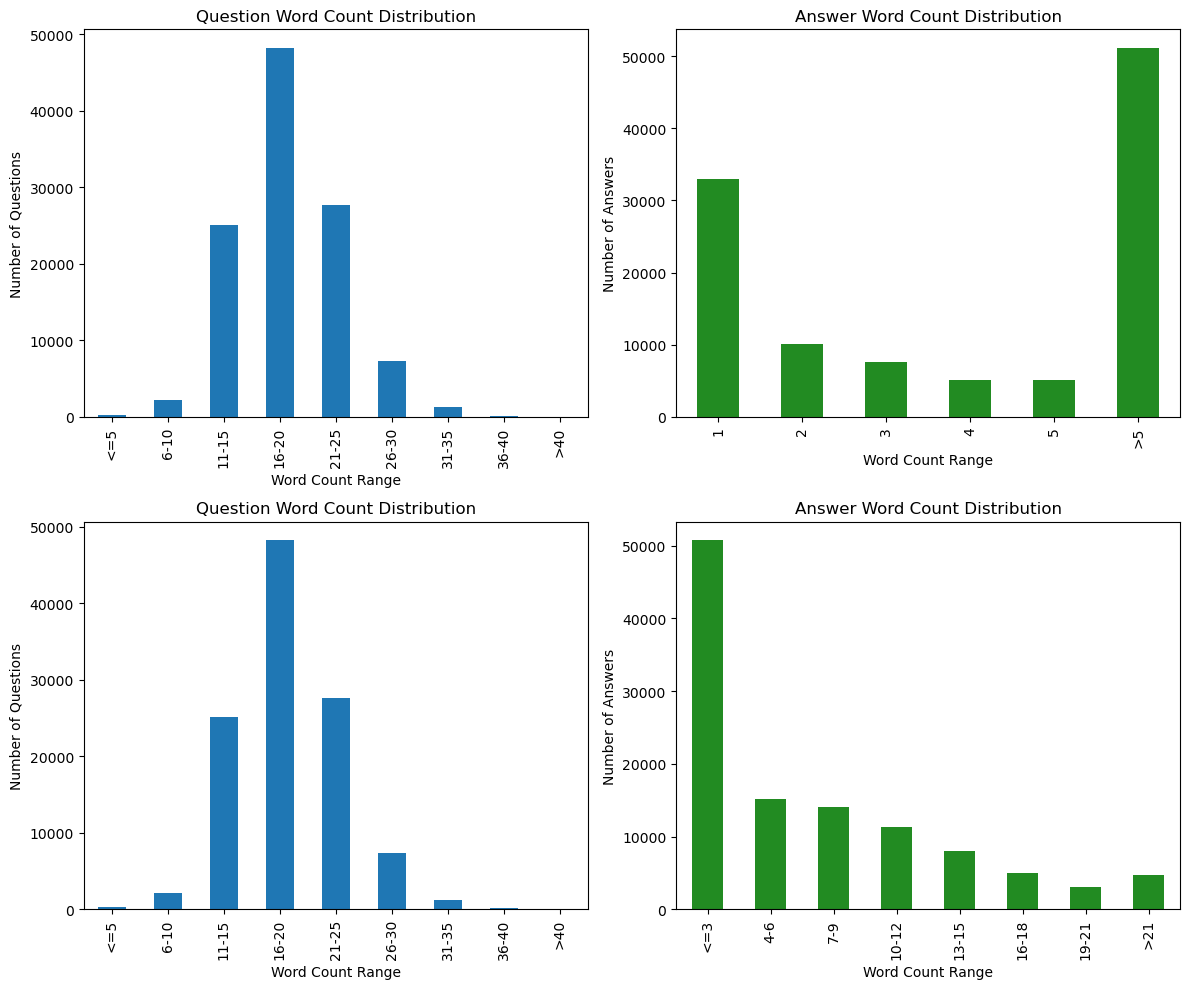

In [10]:
get_qa_pair_statistics(qa_pair_file, "Overall")

Figure results:

Min question length: 3 words
Median question length: 19.0 words
Average question length: 19.76 words
Max question length: 48 words

Min answer length: 1 words
Median answer length: 9.0 words
Average answer length: 10.64 words
Max answer length: 98 words

Word count distribution for questions:
<=5          5
6-10       370
11-15     8905
16-20    26877
21-25    18051
26-30     4973
31-35      813
36-40       77
>40         11
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1      2090
2      2341
3      2841
4      2980
5      3614
>5    46216
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3       7272
4-6      10437
7-9      12349
10-12    10443
13-15     7567
16-18     4835
19-21     3009
>21       4170
Name: Answer word count, dtype: int64


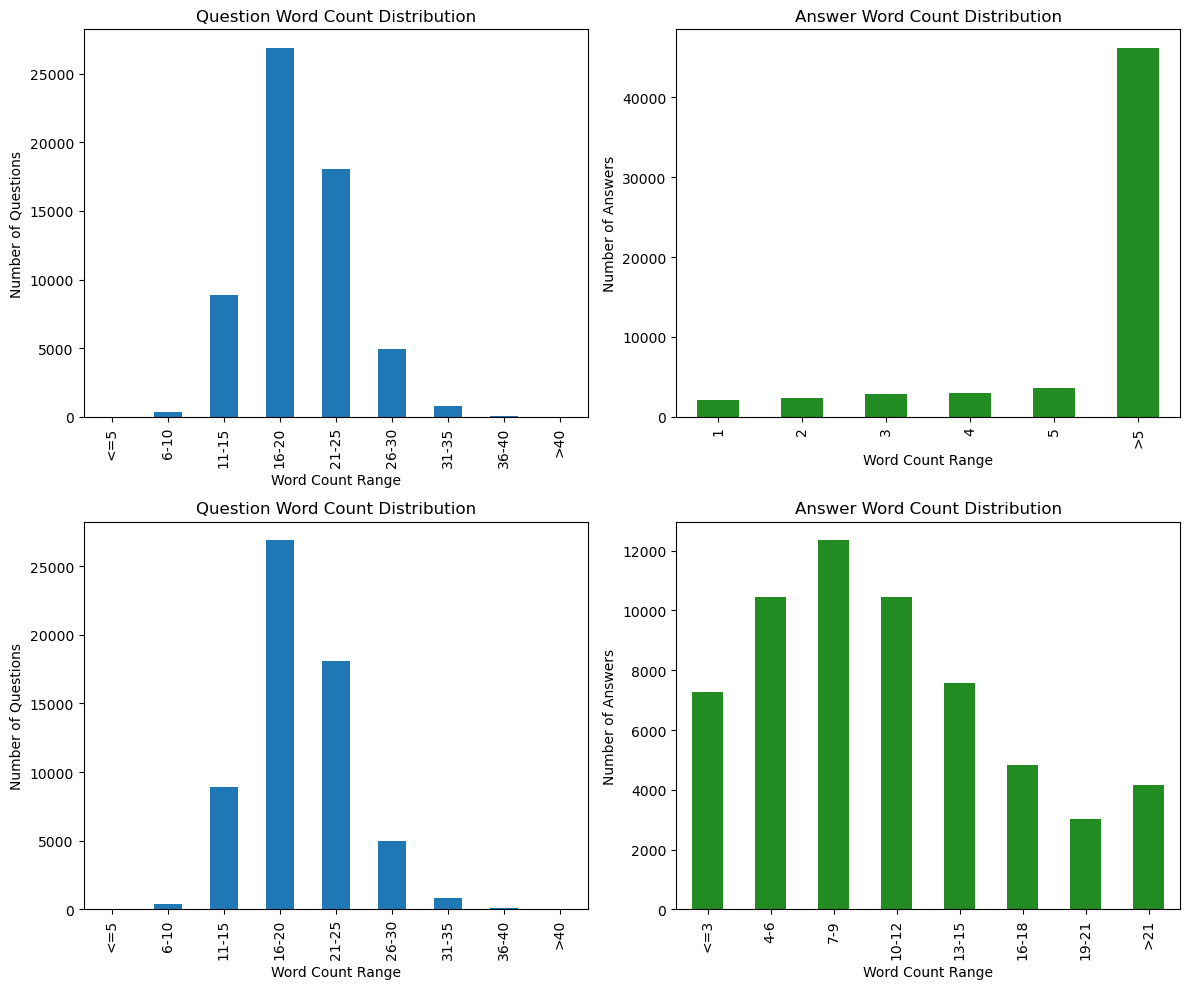

In [11]:
get_qa_pair_statistics(qa_pair_file, "Figure")

Table results:

Min question length: 3 words
Median question length: 17.0 words
Average question length: 17.07 words
Max question length: 47 words

Min answer length: 1 words
Median answer length: 1.0 words
Average answer length: 1.74 words
Max answer length: 145 words

Word count distribution for questions:
<=5         39
6-10      1180
11-15    10020
16-20    10959
21-25     4433
26-30     1082
31-35      181
36-40       23
>40          7
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     19866
2      3948
3      1946
4       709
5       499
>5      956
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      25760
4-6       1454
7-9        371
10-12      155
13-15       73
16-18       43
19-21       21
>21         47
Name: Answer word count, dtype: int64


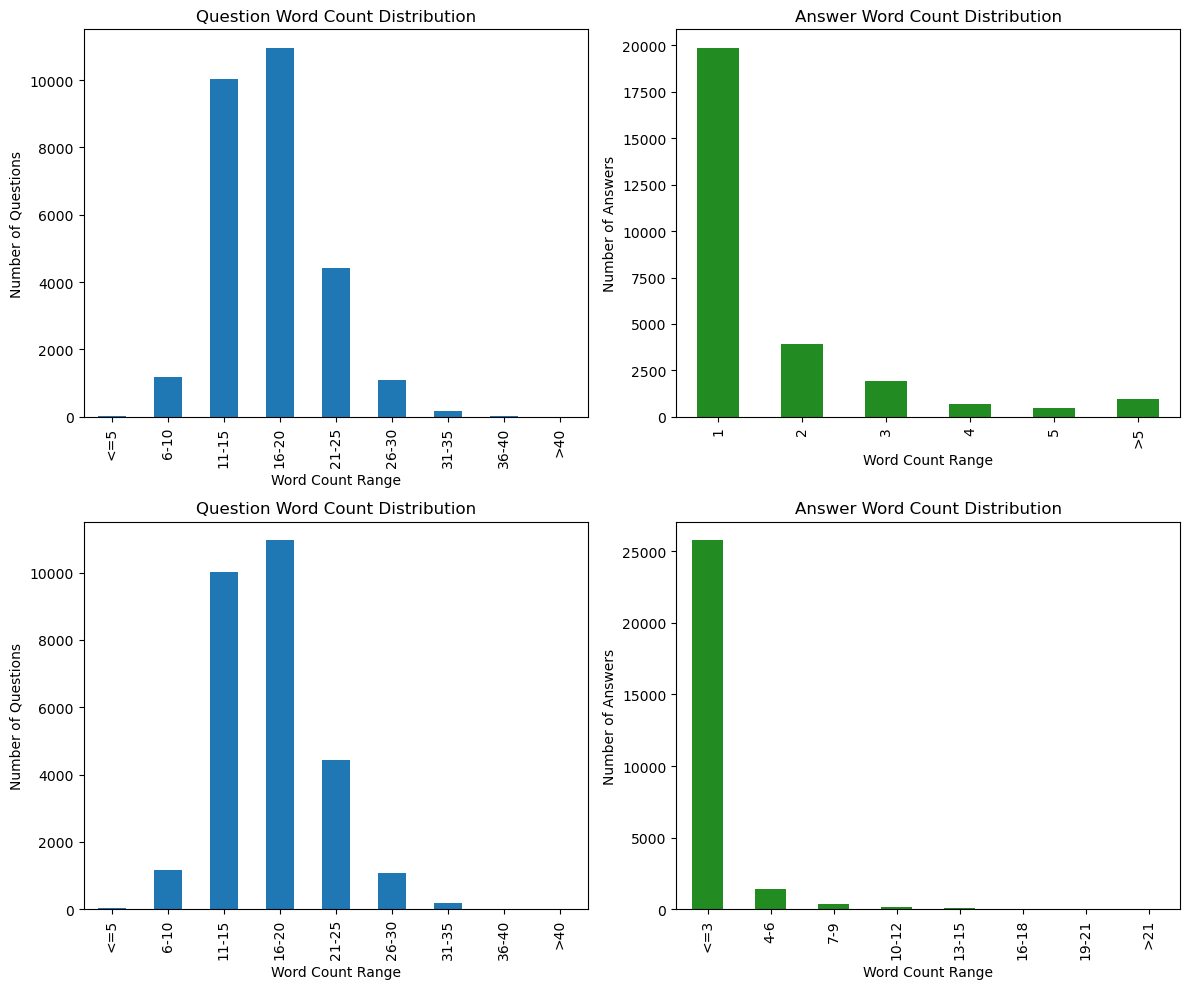

In [12]:
get_qa_pair_statistics(qa_pair_file, "Table")

Table_02 results:

Min question length: 3 words
Median question length: 18.0 words
Average question length: 18.13 words
Max question length: 47 words

Min answer length: 1 words
Median answer length: 2.0 words
Average answer length: 4.06 words
Max answer length: 136 words

Word count distribution for questions:
<=5        214
6-10       620
11-15     6160
16-20    10416
21-25     5159
26-30     1300
31-35      250
36-40       31
>40          4
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     11055
2      3814
3      2842
4      1419
5      1039
>5     3985
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      17711
4-6       3226
7-9       1396
10-12      692
13-15      336
16-18      161
19-21      104
>21        528
Name: Answer word count, dtype: int64


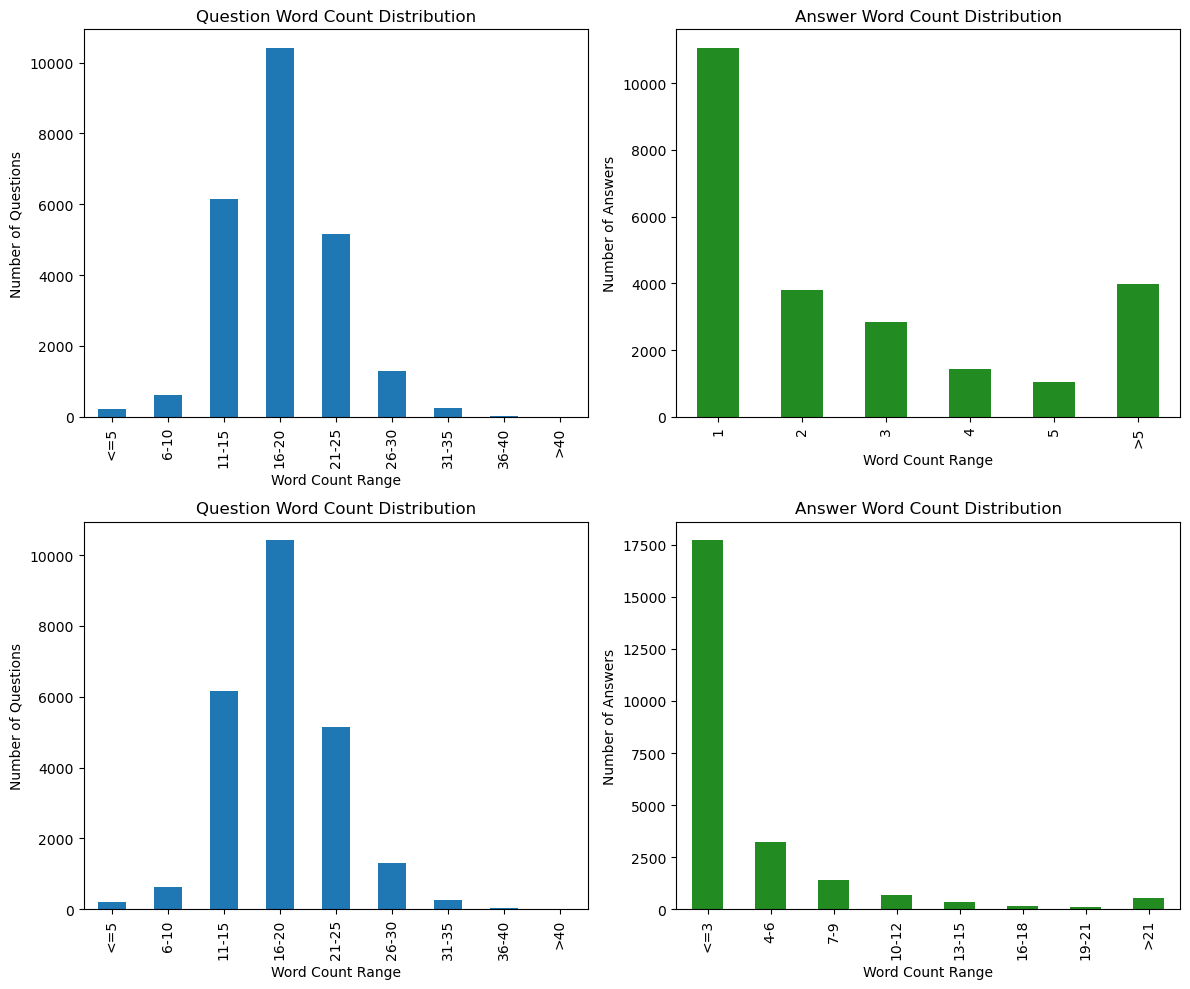

In [13]:
get_qa_pair_statistics(qa_pair_file, "Table_02")

In [14]:
def apply_filtering(input_file, output_file, question_word_threshold, answer_word_threshold):
    """
    Applying the former defined filtering methods on the QA-pair dataset, including 
    filtering out questions without a question mark and not-unique questions.
    
    Args:
        input_file (str): Path to the input file containing the unfiltered QA-pairs.
        output_file (str): Path to the output file in which the filtered QA-pairs shall be stored.
        question_word_threshold (int): Number of words a question is allowed to contain at maximum.
        answer_word_threshold (int): Number of words an answer is allowed to contain at maximum.
    """
    
    # Print current amount of pairs per category
    count_labels(input_file)
    print()
    
    # Obtain pairs to filter out
    corrupted_questions = check_question_ending(input_file)
    not_unique_questions = find_not_unique_questions(input_file)
    too_long_questions = find_long_answers(input_file, question_word_threshold, answer_word_threshold)
    tm_reference_questions = find_text_mention_references(input_file)
    filtered_questions = corrupted_questions.union(not_unique_questions).union(too_long_questions).union(tm_reference_questions)
    
    # Write good rows into a new csv file
    counter_filter = 0
    with open(input_file, "r", encoding="utf-8") as csv_input:
        csv_reader = csv.reader(csv_input, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
        with open(output_file, "w", newline='', encoding="utf-8") as csv_output:
            csv_writer = csv.writer(csv_output, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)

            for row in csv_reader:
                if row[question_index] not in filtered_questions:
                    csv_writer.writerow(row)
                else:
                    counter_filter += 1
                    
    # Print results
    print(f"\n{counter_filter} rows have been filtered.")
    count_labels(output_file)

In [15]:
QUESTION_WORD_THRESHOLD = 28
ANSWER_WORD_THRESHOLD = 18

apply_filtering(qa_pair_file, qa_pair_filtered_file, QUESTION_WORD_THRESHOLD, ANSWER_WORD_THRESHOLD)

Overall: 112160
Figure      60082
Table       27924
Table_02    24154
Name: 1, dtype: int64

132 questions without a question mark were found.
Number of not unique questions: 660
Number of affected pairs: 1613

Examples for not unique questions:
According to Table                                                                                                        216
During which phase does the UAV move along the positive direction of the y-axis in the world frame?                        16
According to the ablation study in Table                                                                                   14
What does Table                                                                                                             8
What is the convergence order of the AFC method when $h_0 = 1/40$?                                                          4
What is the order of convergence for $\|\eps_h\|$ when $h = 1/32$?                                                          

Overall results:

Min question length: 3 words
Median question length: 18.0 words
Average question length: 18.74 words
Max question length: 48 words

Min answer length: 1 words
Median answer length: 5.0 words
Average answer length: 7.01 words
Max answer length: 145 words

Word count distribution for questions:
<=5        258
6-10      2170
11-15    25085
16-20    48252
21-25    27643
26-30     7355
31-35     1244
36-40      131
>40         22
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     33011
2     10103
3      7629
4      5108
5      5152
>5    51157
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      50743
4-6      15117
7-9      14116
10-12    11290
13-15     7976
16-18     5039
19-21     3134
>21       4745
Name: Answer word count, dtype: int64


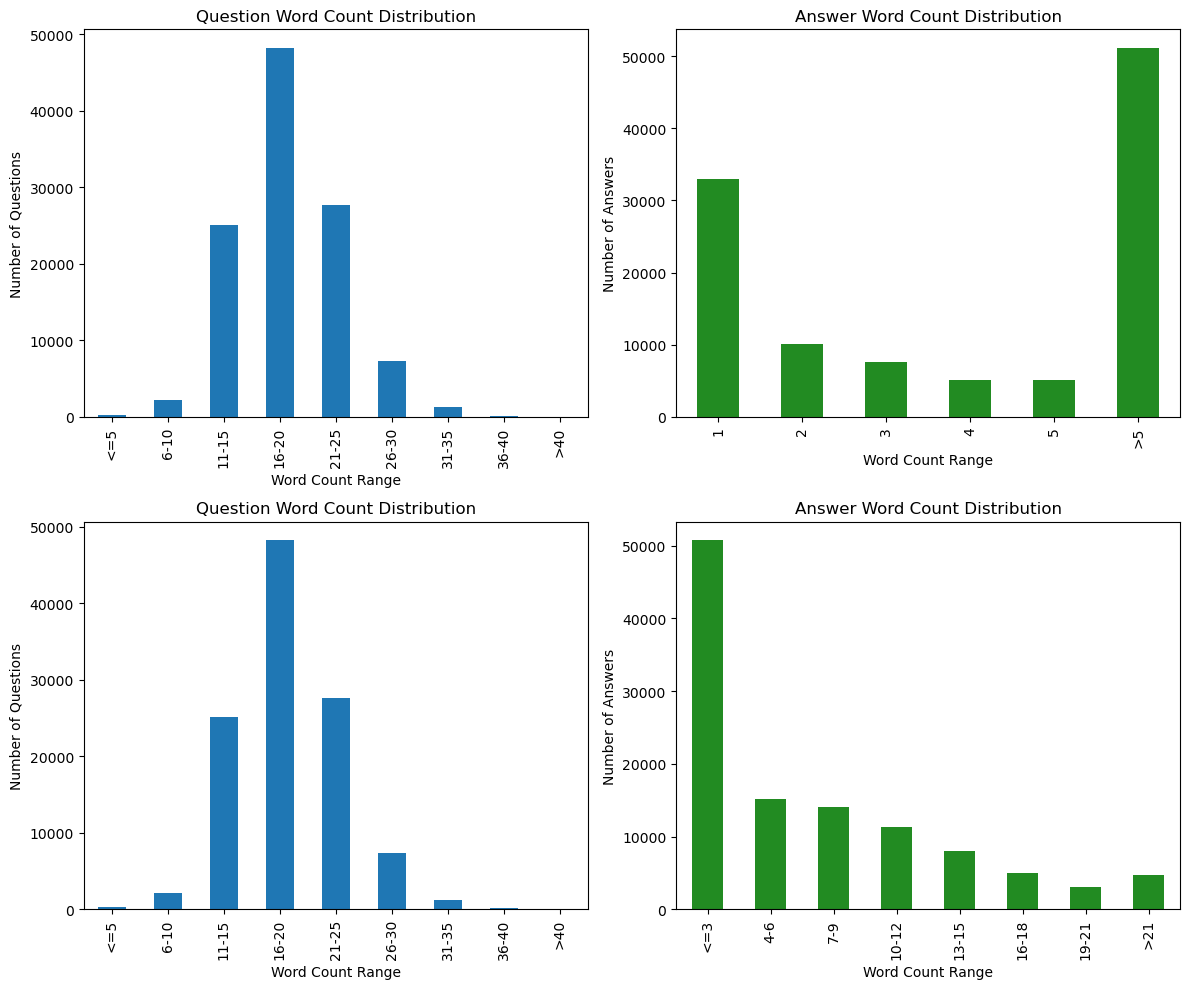

In [16]:
get_qa_pair_statistics(qa_pair_file, "Overall")

Figure results:

Min question length: 3 words
Median question length: 19.0 words
Average question length: 19.76 words
Max question length: 48 words

Min answer length: 1 words
Median answer length: 9.0 words
Average answer length: 10.64 words
Max answer length: 98 words

Word count distribution for questions:
<=5          5
6-10       370
11-15     8905
16-20    26877
21-25    18051
26-30     4973
31-35      813
36-40       77
>40         11
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1      2090
2      2341
3      2841
4      2980
5      3614
>5    46216
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3       7272
4-6      10437
7-9      12349
10-12    10443
13-15     7567
16-18     4835
19-21     3009
>21       4170
Name: Answer word count, dtype: int64


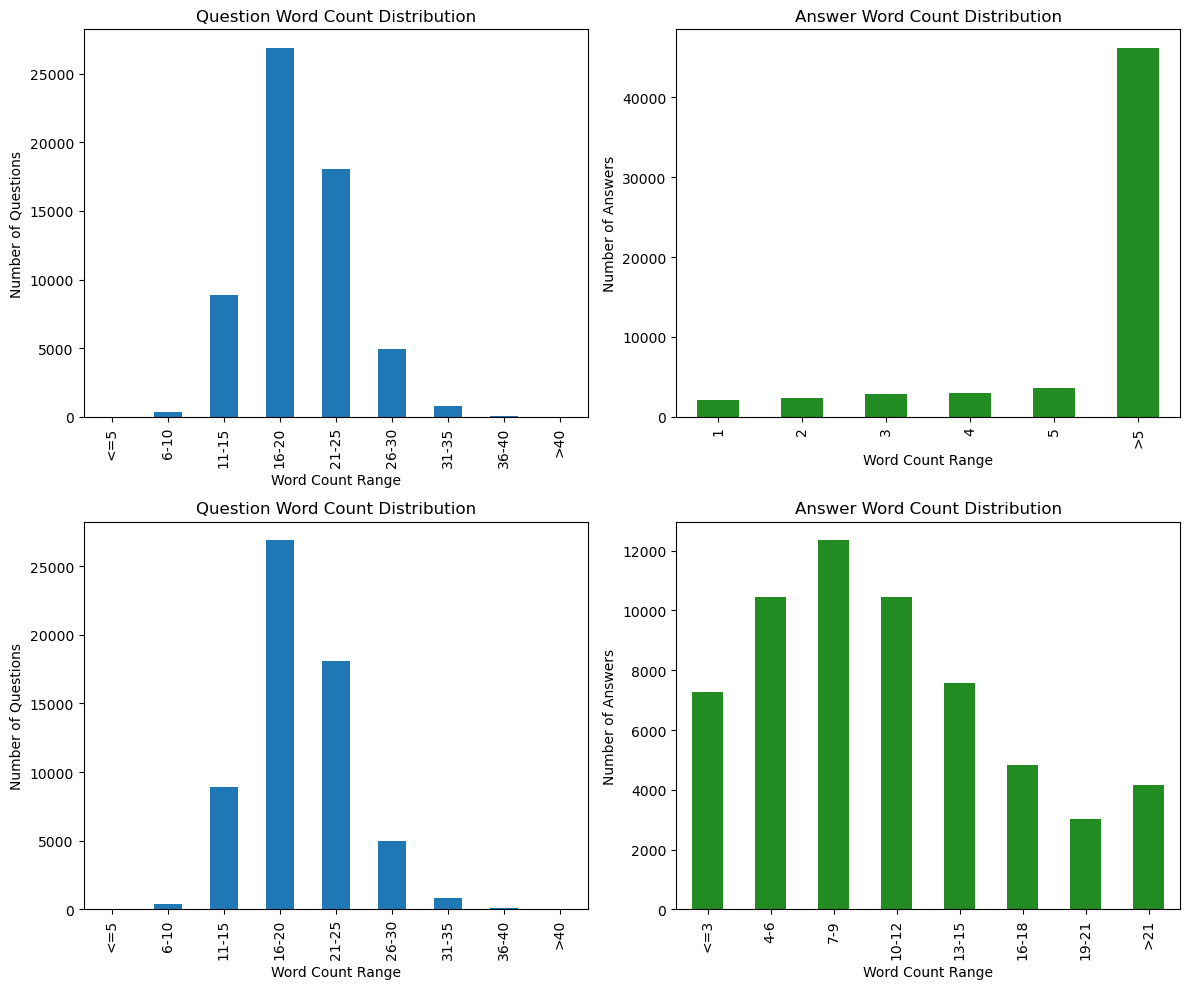

In [17]:
get_qa_pair_statistics(qa_pair_file, "Figure")

Table results:

Min question length: 3 words
Median question length: 17.0 words
Average question length: 17.07 words
Max question length: 47 words

Min answer length: 1 words
Median answer length: 1.0 words
Average answer length: 1.74 words
Max answer length: 145 words

Word count distribution for questions:
<=5         39
6-10      1180
11-15    10020
16-20    10959
21-25     4433
26-30     1082
31-35      181
36-40       23
>40          7
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     19866
2      3948
3      1946
4       709
5       499
>5      956
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      25760
4-6       1454
7-9        371
10-12      155
13-15       73
16-18       43
19-21       21
>21         47
Name: Answer word count, dtype: int64


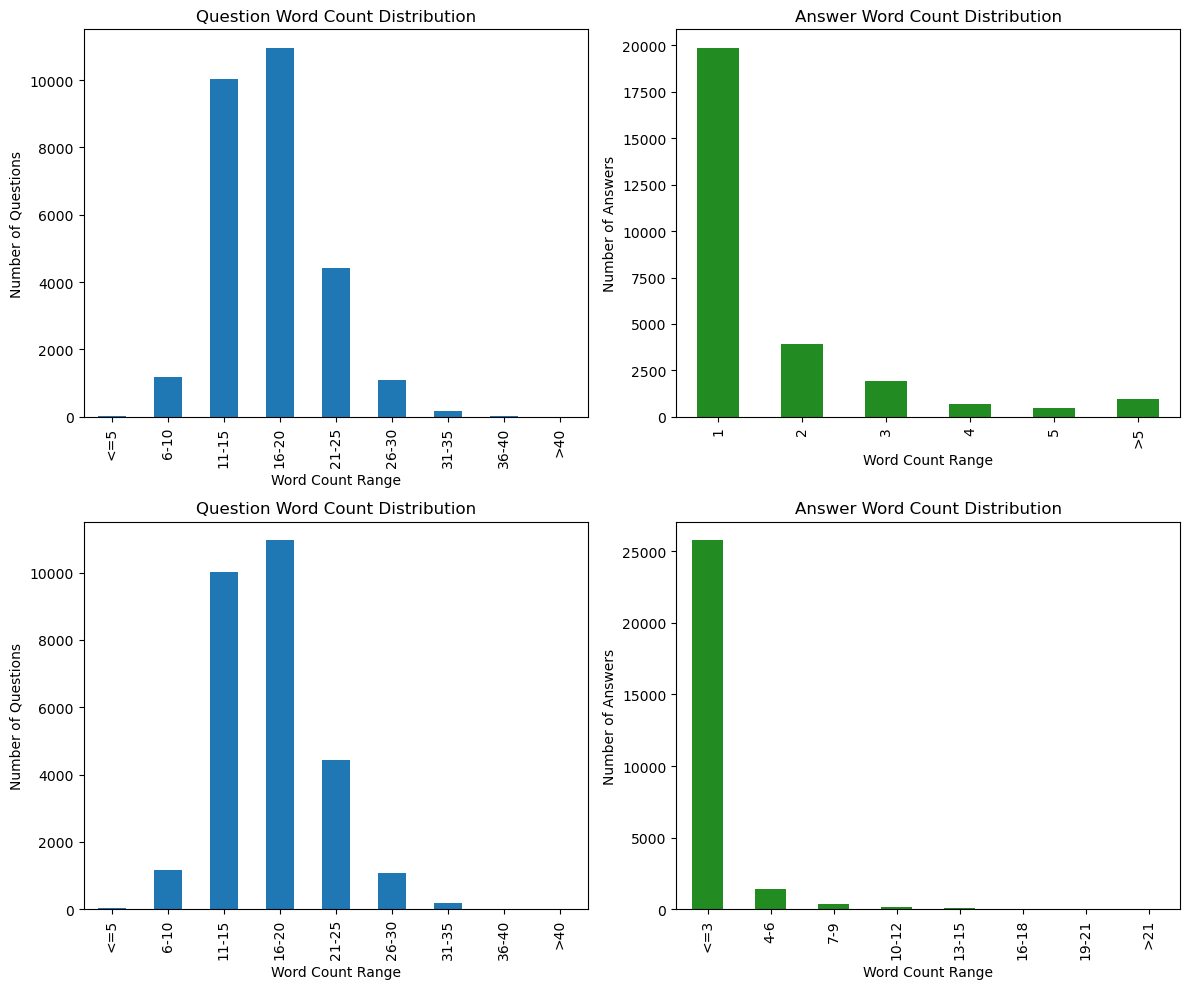

In [18]:
get_qa_pair_statistics(qa_pair_file, "Table")

Table_02 results:

Min question length: 3 words
Median question length: 18.0 words
Average question length: 18.13 words
Max question length: 47 words

Min answer length: 1 words
Median answer length: 2.0 words
Average answer length: 4.06 words
Max answer length: 136 words

Word count distribution for questions:
<=5        214
6-10       620
11-15     6160
16-20    10416
21-25     5159
26-30     1300
31-35      250
36-40       31
>40          4
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     11055
2      3814
3      2842
4      1419
5      1039
>5     3985
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      17711
4-6       3226
7-9       1396
10-12      692
13-15      336
16-18      161
19-21      104
>21        528
Name: Answer word count, dtype: int64


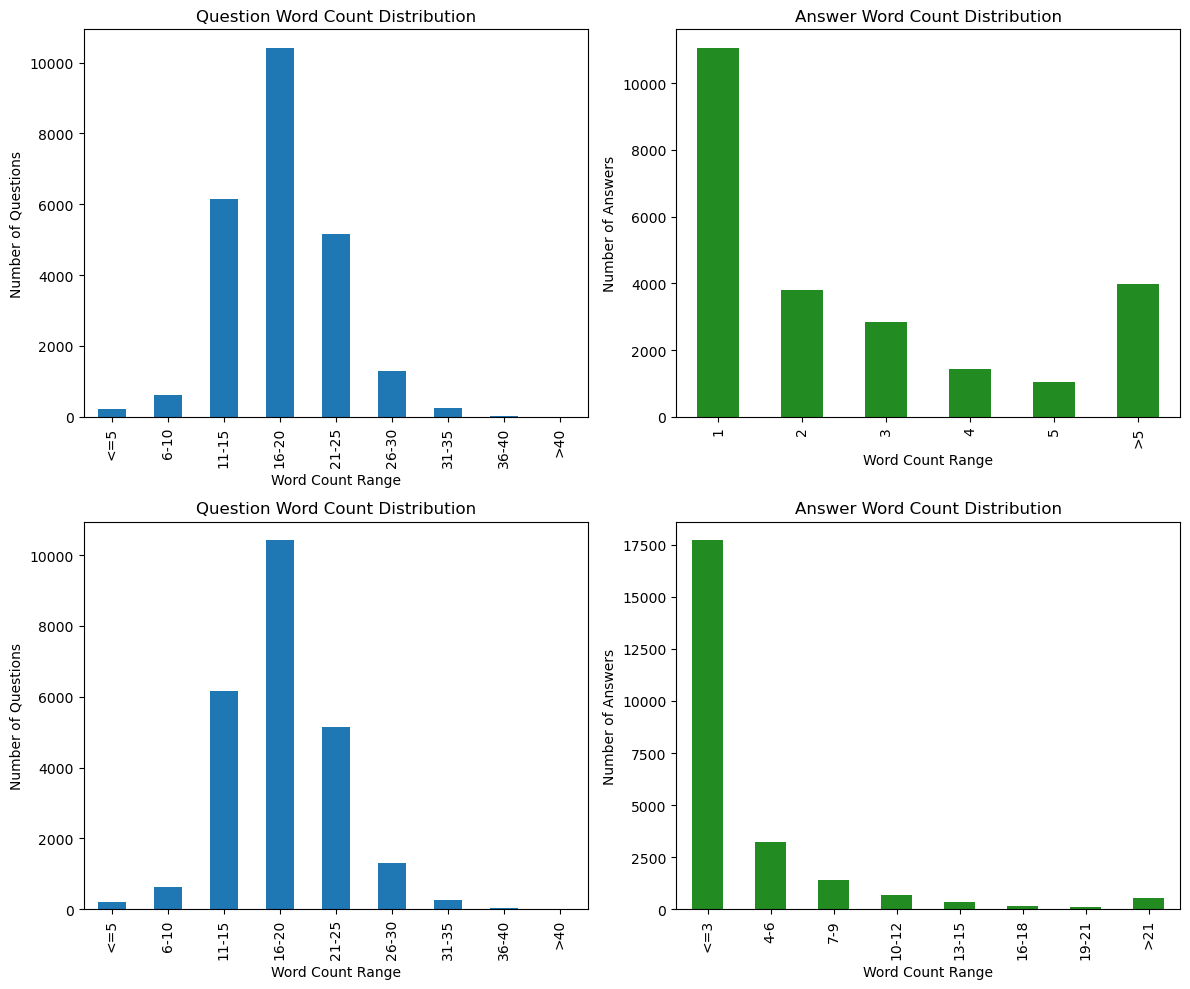

In [19]:
get_qa_pair_statistics(qa_pair_file, "Table_02")